In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
# from keras import optimizers, applications
from keras.preprocessing.image import ImageDataGenerator
import shap
# from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions
# import cv2


/Users/jackyu/Developer/MLIP-I4/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load data
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
print('Number of train samples: ', train.shape[0])
print('Number of test samples: ', test.shape[0])

# Preprocecss data
train["id_code"] = train["id_code"].apply(lambda x: x + ".png")
test["id_code"] = test["id_code"].apply(lambda x: x + ".png")
train['diagnosis'] = train['diagnosis'].astype('str')
test['diagnosis'] = test['diagnosis'].astype('str')
display(train.head())
display(test.head())

Number of train samples:  2929
Number of test samples:  733


,id_code,age,gender,diagnosis
0,e8ddfc9709ce.png,55,F,0
1,c1437a7a52c9.png,64,F,0
2,b8ebedd382de.png,31,M,1
3,9859e2a6cc24.png,62,M,4
4,66b88a4bc474.png,78,F,0


,id_code,age,gender,diagnosis
0,04aef84a2cc1.png,75,F,0
1,4ad8d3ec8789.png,26,F,0
2,cb02bb47fdc5.png,71,F,0
3,c9d42d7534e0.png,70,M,2
4,d5a39339ff3d.png,19,F,2


In [3]:
# Model parameters
BATCH_SIZE = 8
HEIGHT = 320
WIDTH = 320
CANAL = 3
N_CLASSES = train['diagnosis'].nunique()
N_CLASSES = test['diagnosis'].nunique()

In [4]:
# Data generators
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test,
        directory = "data/test_images/",
        x_col="id_code",
        y_col="diagnosis",
        class_mode="categorical",
        batch_size=BATCH_SIZE,
        target_size=(HEIGHT, WIDTH),
        seed=0,
        shuffle=False)

young_generator = test_datagen.flow_from_dataframe(
        dataframe=test[test['age'] < 40 ],
        directory = "data/test_images/",
        x_col="id_code",
        y_col="diagnosis",
        class_mode="categorical",
        batch_size=BATCH_SIZE,
        target_size=(HEIGHT, WIDTH),
        seed=0,
        shuffle=False)

mid_generator = test_datagen.flow_from_dataframe(
        dataframe=test[(test['age'] >= 40) & (test['age'] < 60) ],
        directory = "data/test_images/",
        x_col="id_code",
        y_col="diagnosis",
        class_mode="categorical",
        batch_size=BATCH_SIZE,
        target_size=(HEIGHT, WIDTH),
        seed=0,
        shuffle=False)

old_generator = test_datagen.flow_from_dataframe(
        dataframe=test[test['age'] >= 60 ],
        directory = "data/test_images/",
        x_col="id_code",
        y_col="diagnosis",
        class_mode="categorical",
        batch_size=BATCH_SIZE,
        target_size=(HEIGHT, WIDTH),
        seed=0,
        shuffle=False)
    


Found 731 validated image filenames belonging to 5 classes.
Found 262 validated image filenames belonging to 5 classes.


Found 232 validated image filenames belonging to 5 classes.
Found 237 validated image filenames belonging to 5 classes.


/Users/jackyu/Developer/MLIP-I4/.venv/lib/python3.10/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 2 invalid image filename(s) in x_col="id_code". These filename(s) will be ignored.
  warnings.warn(
/Users/jackyu/Developer/MLIP-I4/.venv/lib/python3.10/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="id_code". These filename(s) will be ignored.
  warnings.warn(
/Users/jackyu/Developer/MLIP-I4/.venv/lib/python3.10/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="id_code". These filename(s) will be ignored.
  warnings.warn(


In [5]:
# Generate 20 test data points
test_generator.batch_size = 20 # background dataset
data, labels = next(test_generator)

In [6]:
# Load model
model = tf.keras.models.load_model("model.h5")

In [7]:
# Generate some predictions
predictions = model.predict(data).argmax(axis=1)

1/1 [==============================] - 2s 2s/step


In [8]:
predictions

array([0, 0, 0, 2, 2, 1, 2, 0, 1, 2, 2, 2, 1, 0, 2, 2, 0, 2, 0, 0])

In [9]:
# Generate explanations
class_names = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR']

# define a masker that is used to mask out partitions of the input image.
masker = shap.maskers.Image("inpaint_ns", data[0].shape)

# create an explainer with model and image masker
explainer = shap.Explainer(model, masker, output_names=class_names)

PartitionExplainer explainer: 2it [00:21, 21.60s/it]               


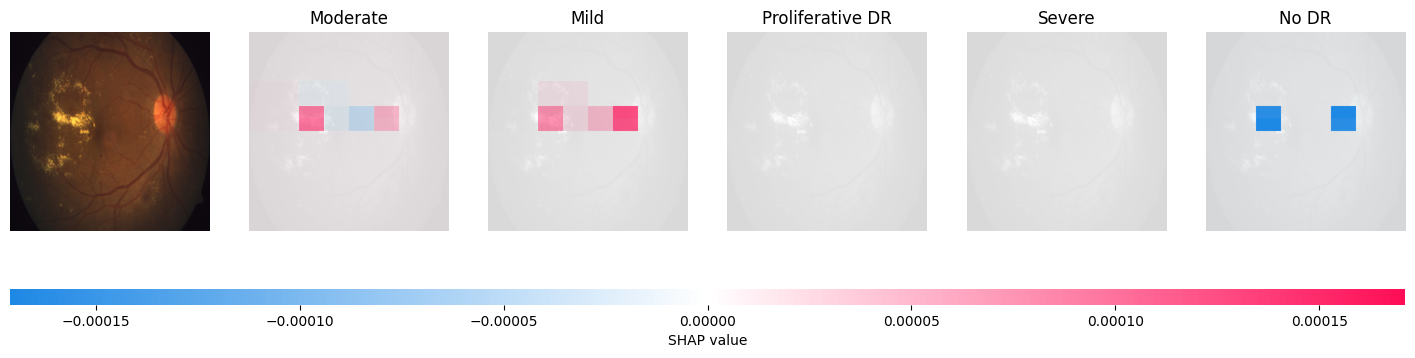

In [19]:
# create an explainer with model and image masker
# here we explain two images using 500 evaluations of the underlying model to estimate the SHAP values
shap_values = explainer(
    data[15][np.newaxis, :], max_evals=250, batch_size=50, outputs=shap.Explanation.argsort.flip[:5]
)
shap.image_plot(shap_values)


In [13]:
diagnosis_dict = {0: 'No DR',
                  1: 'Mild',
                  2: 'Moderate',
                  3: 'Severe',
                  4: 'Proliferative DR'}

## Automatically generate local explainability HTML site

In [16]:
# generator for html template

def generate_html(root_dir, image, prediction, explainer, patient_id):
    html = open("html/explanation_template.html").read()

    html = html.replace("PXX", "John Doe")
    html = html.replace("GXX", "Male")
    html = html.replace("SHAP_FOR_DISPLAY", patient_id)

    shap_values = explainer(image[np.newaxis, :], max_evals=200, batch_size=50)#, outputs=shap.Explanation.argsort.flip[:5])

    shap.image_plot(shap_values, show=False)
    plt.savefig(f'assets/temp/{patient_id}.png')


    html = html.replace("DXX", diagnosis_dict[prediction])

    with open(f"{root_dir}/{patient_id}.html", "w") as fp:
        fp.write(html)

PartitionExplainer explainer: 2it [00:16, 16.09s/it]               


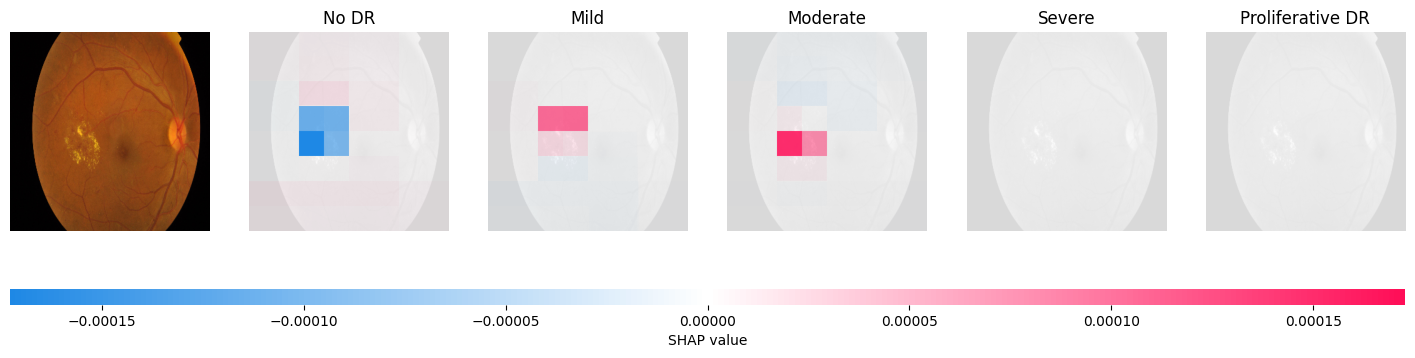

In [17]:
# Populate the html template
i = 4
generate_html("html", data[i], predictions[i], explainer, f'patient_{i}')

PartitionExplainer explainer: 2it [00:17, 17.23s/it]               


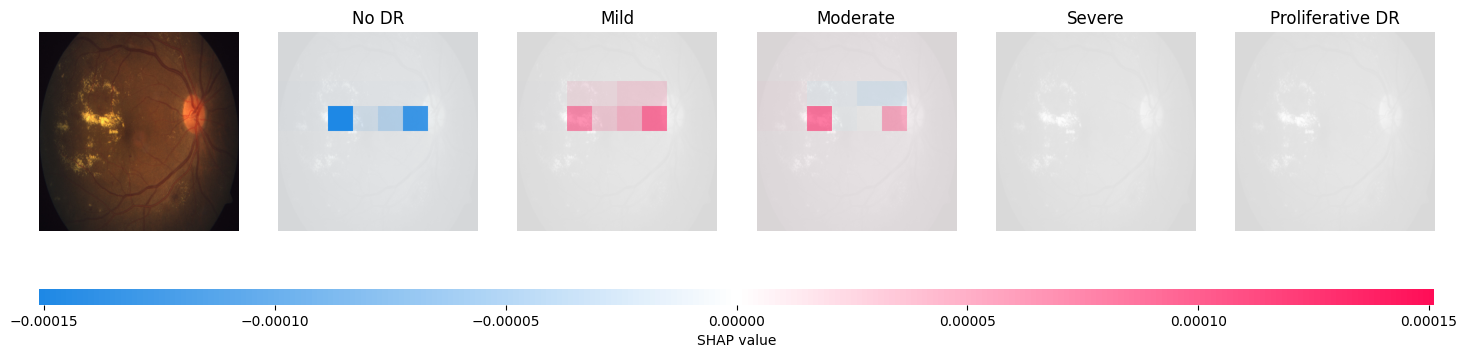

In [20]:
# Populate the html template
i = 15
generate_html("html", data[i], predictions[i], explainer, f'patient_{i}')

## Subgroup evaluation

In [41]:
for generator in [young_generator, mid_generator, old_generator]:
    STEP_SIZE_TEST = generator.n//generator.batch_size
    # preds = model.predict_generator(test_generator, steps=STEP_SIZE_TEST)
    # predictions = [np.argmax(pred) for pred in preds]

    test_preds = np.empty((0, N_CLASSES))
    test_labels = np.empty((0, N_CLASSES))
    for i in range(STEP_SIZE_TEST+1):
        im, lbl = next(generator)
        scores = model.predict(im, batch_size=generator.batch_size)
        test_preds = np.append(test_preds, scores, axis=0)
        test_labels = np.append(test_labels, lbl, axis=0)

    accuracy = (np.argmax(test_preds, axis=1) == np.argmax(test_labels, axis=1)).mean()
    print(f"Accuracy: {accuracy:.1%}")


1/1 [==============================] - 0s 331ms/step
Accuracy: 89.7%
1/1 [==============================] - 0s 450ms/step
Accuracy: 90.8%
1/1 [==============================] - 0s 289ms/step
Accuracy: 84.8%
